## Import Settings

In [18]:
import os

import numpy as np
import cv2

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu


import torch
import numpy as np

import torch.onnx
import onnx 
import onnxruntime

from PIL import Image
import torchvision.transforms as transforms


In [19]:
ROOT = os.path.abspath('../')
import sys 
sys.path.append(ROOT)
import segmentation_models_pytorch as smp


In [20]:
DATA_DIR = '../data/plates_with_masks/'
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_masks')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_masks')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_masks')

In [21]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## Dataset 

In [22]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['carplate']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def scale_img(self,img):
#         scale_percent = 30 # percent of original size
#         width = int(img.shape[1] * scale_percent / 100)
#         height = int(img.shape[0] * scale_percent / 100)
        dim = (1024, 576)
        # resize image
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        if len(resized.shape) != 3:
            resized = np.expand_dims(resized,2)
        return resized
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread('..'+self.masks_fps[i].split('.')[2] + '.png',0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        image = self.scale_img(image)
        mask = self.scale_img(mask)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        print(image.shape, mask.shape)
        return image, mask
        
    def __len__(self):
        return len(self.ids)

(576, 1024, 3) (576, 1024, 1)


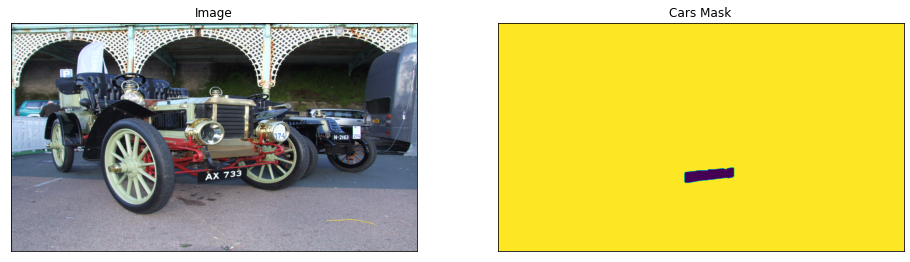

In [23]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['carplate'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [24]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

#         albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0, shift_limit=0.1, p=1),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True),
#         albu.RandomCrop(height=1000, width=1000, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),
#         albu.RandomScale(scale_limit=0.01, interpolation=1, always_apply=True),
#         albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=1.0)
#         albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),
#         albu.Downscale(scale_min=0.01, scale_max=0.5, interpolation=cv2.INTER_NEAREST, always_apply=True, p=1.0),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(320, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

(576, 1024, 3) (576, 1024, 1)
(576, 1024, 3)
(576, 1024, 1)


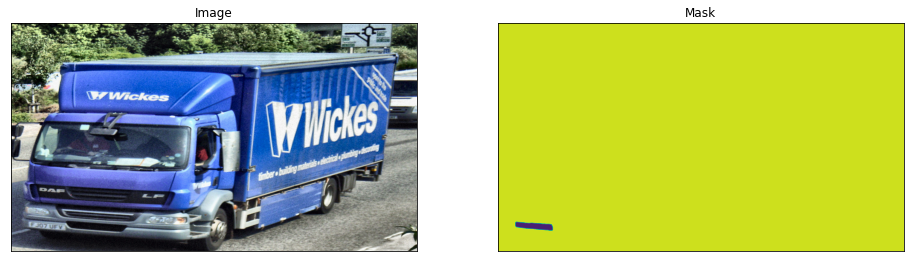

(576, 1024, 3) (576, 1024, 1)
(576, 1024, 3)
(576, 1024, 1)


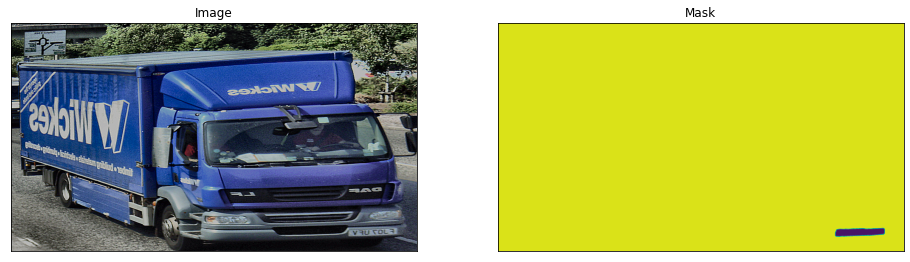

(576, 1024, 3) (576, 1024, 1)
(576, 1024, 3)
(576, 1024, 1)


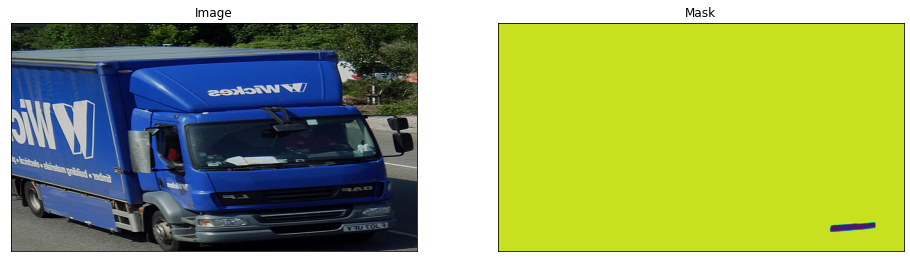

In [25]:
augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['carplate'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[10]
    print(image.shape)
    print(mask.shape)
    visualize(image=image, mask=mask.squeeze(-1))

In [26]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['carplate']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cpu'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [27]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [28]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [29]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

## Train

In [339]:
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/1264 [00:00<?, ?it/s](3, 512, 512) (1, 512, 512)
(3, 512, 512) (1, 512, 512)
(3, 512, 512) (1, 512, 512)
train:   0%|          | 1/1264 [00:37<13:06:57, 37.39s/it, dice_loss - 0.2502, iou_score - 0.6222](3, 512, 512) (1, 512, 512)
(3, 512, 512) (1, 512, 512)
(3, 512, 512) (1, 512, 512)
train:   0%|          | 1/1264 [00:45<15:48:39, 45.07s/it, dice_loss - 0.2502, iou_score - 0.6222]


KeyboardInterrupt: 

## Validate

In [30]:
best_model = torch.load('../models/segmentation_unet/best_model.pth', map_location=torch.device('cpu'))


/Users/dmitry/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'segmentation_models_pytorch.unet.decoder.DecoderBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/dmitry/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'segmentation_models_pytorch.base.modules.Conv2dReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [31]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)
test_dataloader = DataLoader(test_dataset)


In [32]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

In [33]:
logs = test_epoch.run(test_dataloader)


valid: 100%|██████████| 10/10 [00:52<00:00,  5.21s/it, dice_loss - 0.01028, iou_score - 0.9861]


In [34]:
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

(576, 1024, 3) (576, 1024, 1)
(3, 576, 1024) (1, 576, 1024)
Type <class 'numpy.ndarray'>
Input shape (3, 576, 1024)
Vis shape (576, 1024, 3)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[0. 1.]


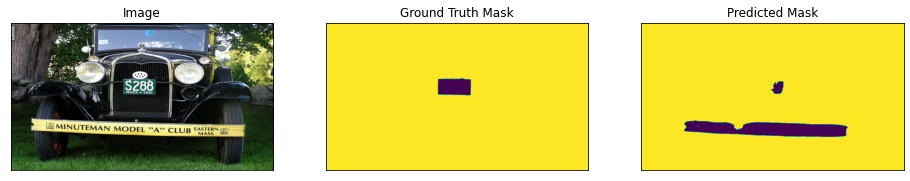

(576, 1024, 3) (576, 1024, 1)
(3, 576, 1024) (1, 576, 1024)
Type <class 'numpy.ndarray'>
Input shape (3, 576, 1024)
Vis shape (576, 1024, 3)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[0. 1.]


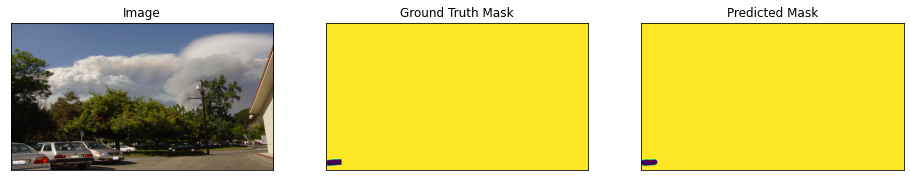

(576, 1024, 3) (576, 1024, 1)
(3, 576, 1024) (1, 576, 1024)
Type <class 'numpy.ndarray'>
Input shape (3, 576, 1024)
Vis shape (576, 1024, 3)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[1.]


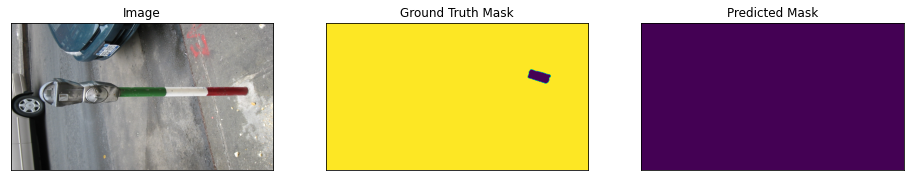

(576, 1024, 3) (576, 1024, 1)
(3, 576, 1024) (1, 576, 1024)
Type <class 'numpy.ndarray'>
Input shape (3, 576, 1024)
Vis shape (576, 1024, 3)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[0. 1.]


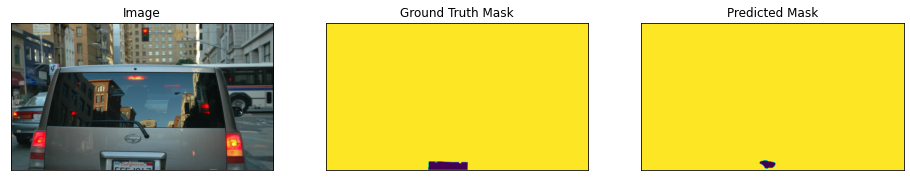

(576, 1024, 3) (576, 1024, 1)
(3, 576, 1024) (1, 576, 1024)
Type <class 'numpy.ndarray'>
Input shape (3, 576, 1024)
Vis shape (576, 1024, 3)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[0. 1.]


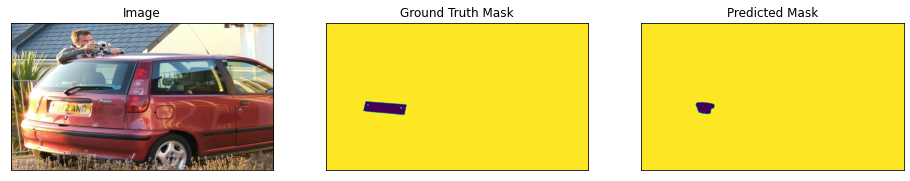

(576, 1024, 3) (576, 1024, 1)
(3, 576, 1024) (1, 576, 1024)
Type <class 'numpy.ndarray'>
Input shape (3, 576, 1024)
Vis shape (576, 1024, 3)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[0. 1.]


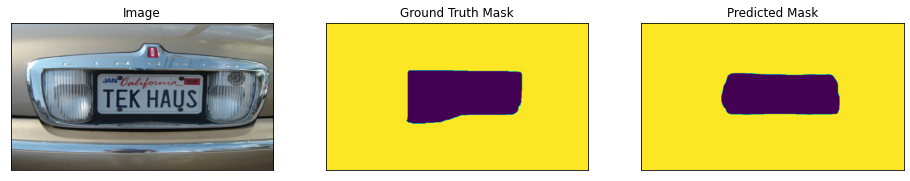

(576, 1024, 3) (576, 1024, 1)
(3, 576, 1024) (1, 576, 1024)
Type <class 'numpy.ndarray'>
Input shape (3, 576, 1024)
Vis shape (576, 1024, 3)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[0. 1.]


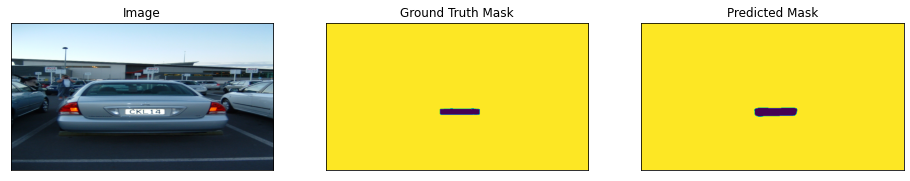

(576, 1024, 3) (576, 1024, 1)
(3, 576, 1024) (1, 576, 1024)
Type <class 'numpy.ndarray'>
Input shape (3, 576, 1024)
Vis shape (576, 1024, 3)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[0. 1.]


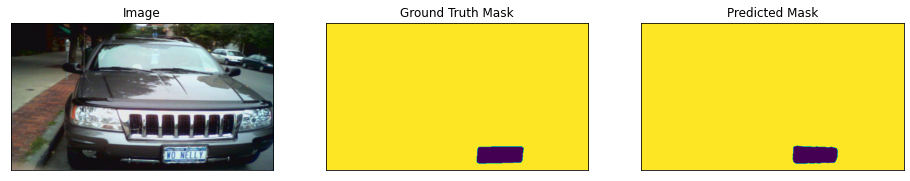

(576, 1024, 3) (576, 1024, 1)
(3, 576, 1024) (1, 576, 1024)
Type <class 'numpy.ndarray'>
Input shape (3, 576, 1024)
Vis shape (576, 1024, 3)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[0. 1.]


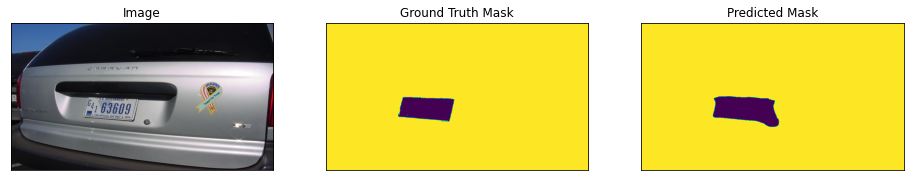

(576, 1024, 3) (576, 1024, 1)
(3, 576, 1024) (1, 576, 1024)
Type <class 'numpy.ndarray'>
Input shape (3, 576, 1024)
Vis shape (576, 1024, 3)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[0. 1.]


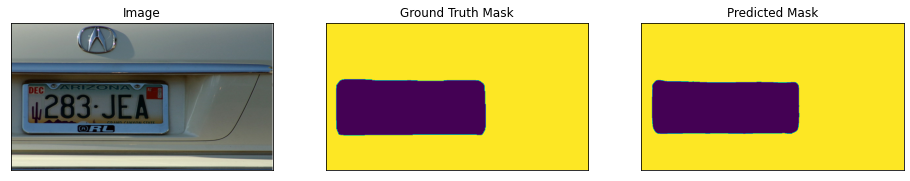

In [35]:
for i in range(10):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    
    gt_mask = gt_mask.squeeze()
    
    print("Type {}".format(type(image)))
    print("Input shape {}".format(image.shape))
    print("Vis shape {}".format(image_vis.shape))
#     print("Normalized data {}".format(image))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    print(pr_mask)
    print(np.unique(pr_mask))
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

## Predit without ground truth

In [36]:
ROOT = os.path.abspath('../')

In [37]:
def scale_img(img):
    dim = (1024, 576)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    if len(resized.shape) != 3:
        resized = np.expand_dims(resized,2)
    return resized

In [38]:
def testset_aug(preprocessing_fn):
    test_transform = [
        albu.PadIfNeeded(320, 480)
    ]
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose([test_transform,_transform])
    

['img8.jpg', 'img5.jpg', 'img4.jpg', 'img6.jpg', 'img7.jpg', 'img3.jpg', 'img2.jpg', 'img1.jpg']


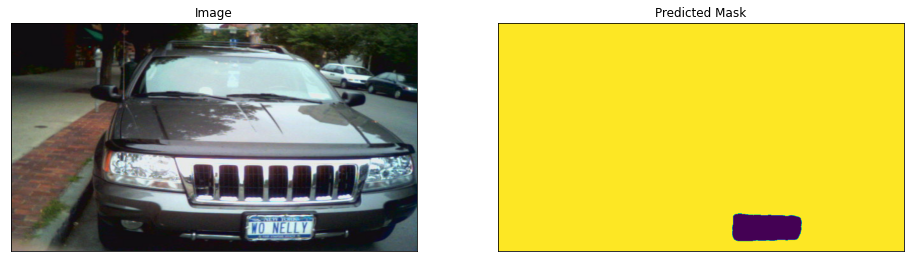

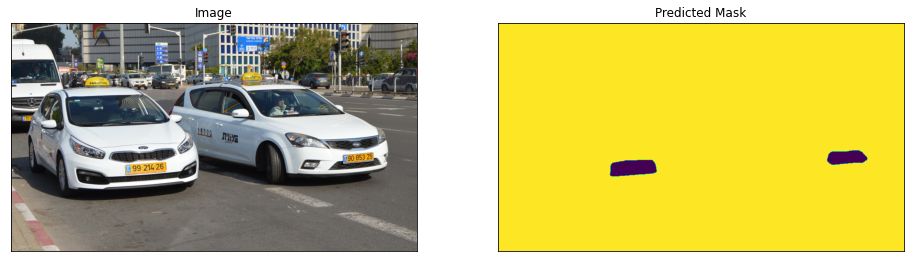

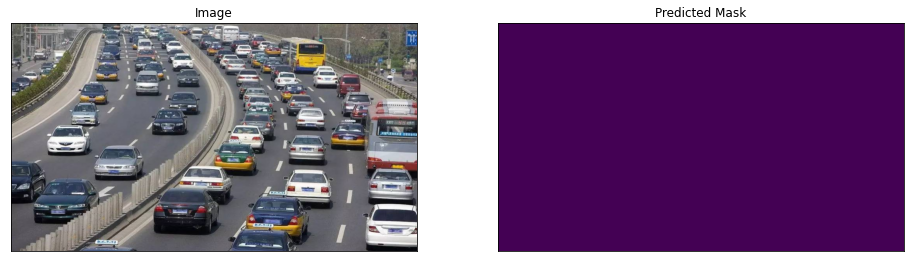

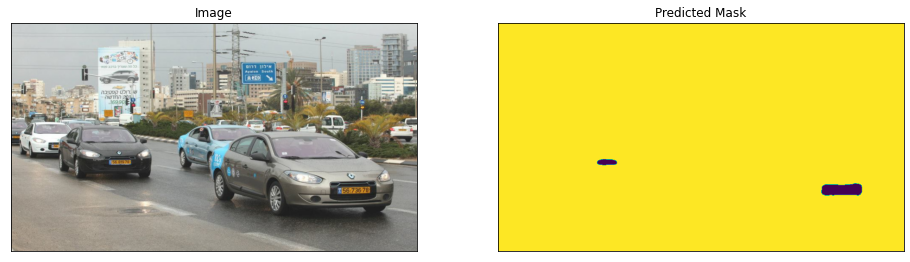

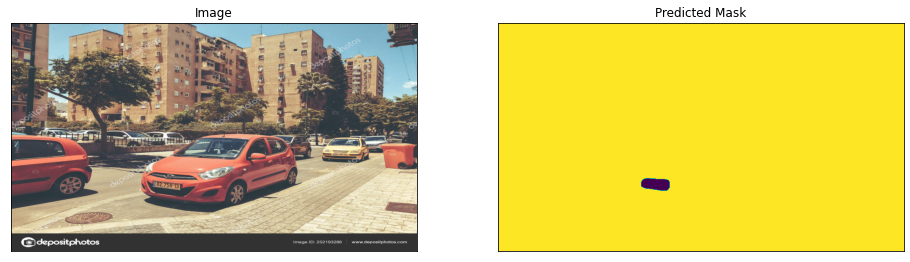

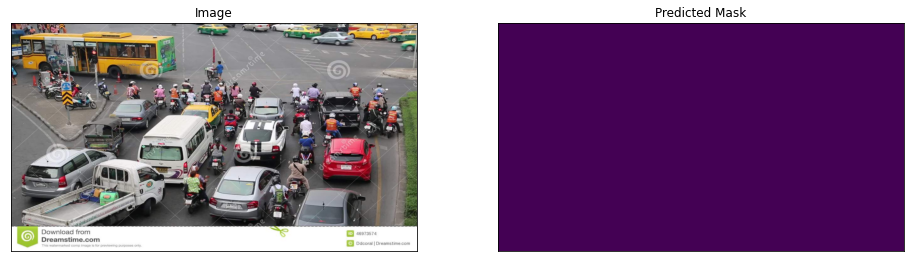

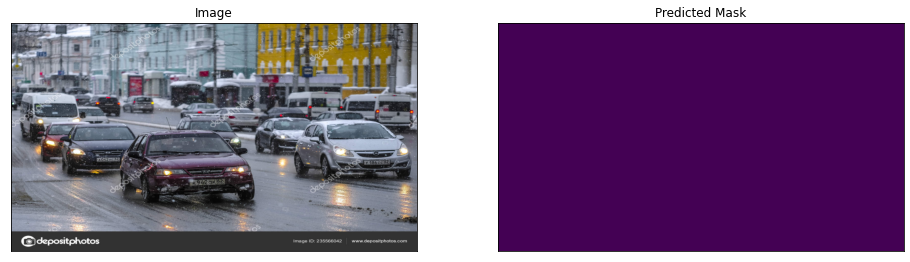

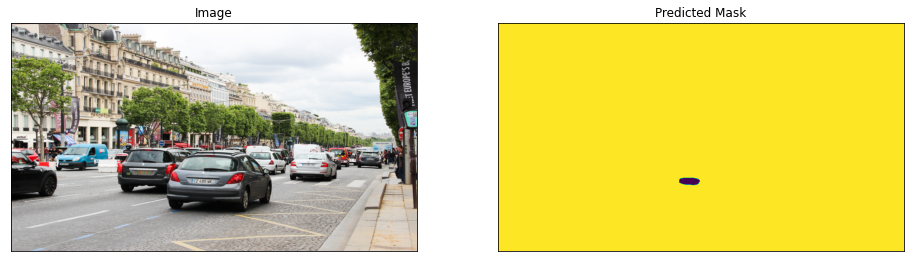

In [40]:
images = os.listdir(os.path.join(ROOT,'data/plates_with_masks/testset'))
preprocessing = get_preprocessing(preprocessing_fn)
print(images)
for i in range(len(images)):
    images = os.listdir(os.path.join(ROOT,'data/plates_with_masks/testset'))
    image = cv2.imread(os.path.join(ROOT,'data/plates_with_masks/testset',images[i]))
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = scale_img(image)
    image_vis = image.astype('uint8')
    
#     image = image.transpose(2, 0, 1).astype('float32')
    sample = preprocessing(image=image)
    
    image = sample['image']
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    visualize(
        image=image_vis, 
#         ground_truth_mask=pr_mask, 
        predicted_mask=pr_mask
    )

## Torch to ONNX

In [52]:

torch_model = torch.load('../models/segmentation_unet/best_model.pth', map_location=torch.device('cuda'))

In [53]:
x = torch.randn(1, 3, 1024, 576, requires_grad=True)
torch_out = torch_model(x)

In [54]:
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "../models/segmentation_unet/super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

AttributeError: 'Tensor' object has no attribute 'state_dict'

## Inference on ONNX

In [30]:
onnx_model = onnx.load("../models/segmentation_unet/super_resolution.onnx")
onnx.checker.check_model(onnx_model)

In [31]:
ort_session = onnxruntime.InferenceSession("../models/segmentation_unet/super_resolution.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)
print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Fail: [ONNXRuntimeError] : 1 : FAIL : Fatal error: ATen is not a registered function/op

In [18]:

img = Image.open("../data/plates_with_masks/testset/img1.jpg")

resize = transforms.Resize([1024, 576])
img = resize(img)

# img_ycbcr = img.convert('YCbCr')
# img_y, img_cb, img_cr = img_ycbcr.split()

to_tensor = transforms.ToTensor()
img = to_tensor(img)
img.unsqueeze_(0)

tensor([[[[0.8039, 0.6980, 0.4275,  ..., 0.0745, 0.0745, 0.0627],
          [0.7882, 0.6980, 0.4549,  ..., 0.0784, 0.0706, 0.0667],
          [0.8118, 0.7098, 0.4588,  ..., 0.0784, 0.0706, 0.0627],
          ...,
          [0.6627, 0.6706, 0.6824,  ..., 0.8824, 0.8902, 0.8863],
          [0.6549, 0.6667, 0.6627,  ..., 0.8784, 0.8824, 0.8824],
          [0.6235, 0.6392, 0.6392,  ..., 0.8863, 0.8706, 0.8706]],

         [[0.5451, 0.6314, 0.3451,  ..., 0.0824, 0.0824, 0.0784],
          [0.5176, 0.6314, 0.3412,  ..., 0.0863, 0.0824, 0.0863],
          [0.5412, 0.6353, 0.3333,  ..., 0.0824, 0.0824, 0.0902],
          ...,
          [0.6510, 0.6549, 0.6471,  ..., 0.7882, 0.8000, 0.7961],
          [0.6314, 0.6431, 0.6275,  ..., 0.7922, 0.7882, 0.7922],
          [0.5961, 0.6118, 0.6118,  ..., 0.8000, 0.7882, 0.7961]],

         [[0.4784, 0.5647, 0.2902,  ..., 0.0353, 0.0314, 0.0196],
          [0.4588, 0.5608, 0.2980,  ..., 0.0392, 0.0314, 0.0275],
          [0.4863, 0.5647, 0.2980,  ..., 0

In [19]:
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img)}
ort_outs = ort_session.run(None, ort_inputs)
img_out_y = ort_outs[0]

In [20]:
img_out_y = Image.fromarray(np.uint8((img_out_y[0] * 255.0).clip(0, 255)[0]), mode='L')

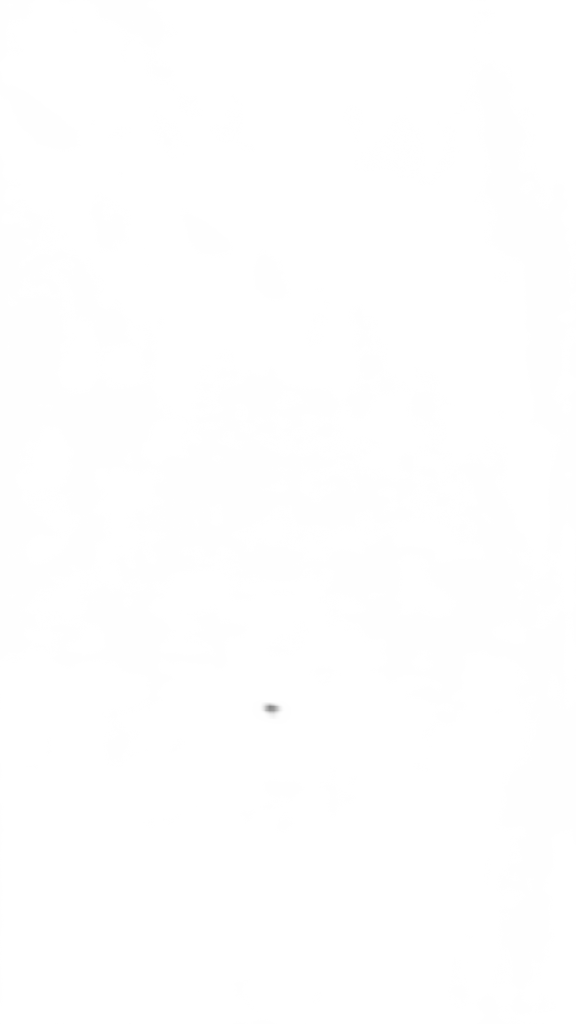

In [21]:
img_out_y